<a href="https://colab.research.google.com/github/jiyoung37/Plant-disease-recognition/blob/main/2_F_4_VGG16_twoStep_4_unfrozen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import

**1.1 Import kagglehub and download dataset**

In [ ]:
!pip install kagglehub
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [02:08<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


**1.2 Define the paths**

In [ ]:
import os

# Define the dataset path
root_folder = "/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2"

data_dir = os.path.join(root_folder, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/')

test_path = os.path.join(root_folder, 'test/test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

# Count the number of folders in a directory
def count_folders(path):
    if os.path.exists(path):
        return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Count the number of files in a directory
def count_files(path):
    if os.path.exists(path):
        return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Function to count files in each folder of a given directory
def count_files_in_folders(path):
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return {}

    folder_file_counts = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_file_counts[folder] = file_count

    return folder_file_counts

# Print counts
print(f"Number of folders in train_path: {count_folders(train_path)}")
print(f"Number of folders in valid_path: {count_folders(valid_path)}")
print(f"Number of files in test_path: {count_files(test_path)}")
print('-------------------------------------------------------------------')
# Count files in each folder
train_folder_counts = count_files_in_folders(train_path)
valid_folder_counts = count_files_in_folders(valid_path)
# Display results
print("Files in each folder (train_path):")
for folder, count in train_folder_counts.items():
    print(f"{folder}: {count} files")

print("\nFiles in each folder (valid_path):")
for folder, count in valid_folder_counts.items():
    print(f"{folder}: {count} files")

Number of folders in train_path: 38
Number of folders in valid_path: 38
Number of files in test_path: 33
-------------------------------------------------------------------
Files in each folder (train_path):
Apple___healthy: 2008 files
Strawberry___Leaf_scorch: 1774 files
Tomato___Early_blight: 1920 files
Tomato___Tomato_mosaic_virus: 1790 files
Raspberry___healthy: 1781 files
Tomato___Bacterial_spot: 1702 files
Soybean___healthy: 2022 files
Tomato___Leaf_Mold: 1882 files
Potato___Late_blight: 1939 files
Apple___Cedar_apple_rust: 1760 files
Potato___healthy: 1824 files
Apple___Black_rot: 1987 files
Orange___Haunglongbing_(Citrus_greening): 2010 files
Grape___healthy: 1692 files
Grape___Black_rot: 1888 files
Tomato___healthy: 1926 files
Apple___Apple_scab: 2016 files
Tomato___Target_Spot: 1827 files
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 files
Tomato___Late_blight: 1851 files
Grape___Esca_(Black_Measles): 1920 files
Cherry_(including_sour)___Powdery_mildew: 1683 files
Grape___Leaf

# 2. Importing necessary libraries for Modeling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

import tensorflow as tf
# Check GPU availability
if tf.config.list_physical_devices('GPU'):
    print("OK! GPU is available and ready for use!")
else:
    print("NO! GPU not found. Falling back to CPU.")

import PIL
import scipy

print(PIL.__version__)
print(scipy.__version__)

OK! GPU is available and ready for use!
11.1.0
1.13.1


# Model 3: Transfer learning-VGG16 with one step, 70k

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os
#import math
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

#Define model name
Model_name = 'F_3-4_VGG16_twoStep-3-unfrozen_20250116'

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
lr = 0.0001

# Define paths
train_path = train_path
valid_path = valid_path

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)

val_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

# Load VGG16 without the top layer, use pretrained ImageNet weights
vgg16_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze all layers in VGG16 base
for layer in vgg16_base.layers:
    layer.trainable = False

# Define the transfer learning model
model = Sequential([
    vgg16_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
callbacks = [
    #EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(f"{Model_name}.keras", save_best_only=True)
]


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
vgg16_base.summary()

In [ ]:
# Train the model
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose = 1
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 138s 58ms/step - accuracy: 0.1822 - loss: 3.2395 - val_accuracy: 0.6661 - val_loss: 1.8852
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 113s 52ms/step - accuracy: 0.5190 - loss: 1.8416 - val_accuracy: 0.7527 - val_loss: 1.2040
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 114s 52ms/step - accuracy: 0.6392 - loss: 1.3066 - val_accuracy: 0.7928 - val_loss: 0.9100
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 113s 51ms/step - accuracy: 0.7026 - loss: 1.0475 - val_accuracy: 0.8176 - val_loss: 0.7493
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accuracy: 0.7386 - loss: 0.8985 - val_accuracy: 0.8342 - val_loss: 0.6498


In [ ]:
# Unfreeze the all layers of VGG16 base
for layer in vgg16_base.layers[-4:]:
    layer.trainable = True

# Start the timer
import time
start_time = time.time()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model
history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    initial_epoch=5,
    callbacks=callbacks
)

# Best epoch with best validation loss
# best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
# print(f"The best model was saved at epoch {best_epoch}.")

# # End the timer
# end_time = time.time()
# # Calculate total and average step times
# total_time = end_time - start_time
# num_steps = sum(len(train_generator) for _ in range(EPOCHS))  # Total steps across all epochs
# average_step_time = total_time / num_steps

# hours = int(total_time // 3600)
# minutes = int((total_time % 3600) // 60)
# print(f"Total running time: {hours}h {minutes}m")
# print(f"Average step time: {average_step_time:.4f} seconds")

Epoch 6/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 129s 56ms/step - accuracy: 0.8223 - loss: 0.5617 - val_accuracy: 0.9318 - val_loss: 0.2143
Epoch 7/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accuracy: 0.9071 - loss: 0.2851 - val_accuracy: 0.9552 - val_loss: 0.1410
Epoch 8/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 116s 53ms/step - accuracy: 0.9343 - loss: 0.2046 - val_accuracy: 0.9649 - val_loss: 0.1085
Epoch 9/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 114s 52ms/step - accuracy: 0.9479 - loss: 0.1593 - val_accuracy: 0.9674 - val_loss: 0.0998
Epoch 10/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 116s 53ms/step - accuracy: 0.9584 - loss: 0.1272 - val_accuracy: 0.9740 - val_loss: 0.0808
Epoch 11/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accuracy: 0.9664 - loss: 0.1046 - val_accuracy: 0.9719 - val_loss: 0.0818
Epoch 12/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 116s 53ms/step - accuracy: 0.9715 - loss: 0.0876 - val_accuracy: 0.9754 - val_loss: 0.0734
Epoch 13/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accura

In [ ]:
# Best epoch with best validation loss
best_epoch = history_phase2.history['val_loss'].index(min(history_phase2.history['val_loss'])) + 1
print(f"The best model was saved at epoch {best_epoch}.")

The best model was saved at epoch 31.


In [ ]:
# End the timer
end_time = time.time()
# Calculate total and average step times
total_time = end_time - start_time
num_steps = sum(len(train_generator) for _ in range(EPOCHS))  # Total steps across all epochs
average_step_time = total_time / num_steps

hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
print(f"Total running time: {hours}h {minutes}m")
print(f"Average step time: {average_step_time:.4f} seconds")

Total running time: 2h 8m
Average step time: 0.0704 seconds


In [ ]:
# Combine training and validation histories
history_combined = {
    "accuracy": history_phase1.history["accuracy"] + history_phase2.history["accuracy"],
    "val_accuracy": history_phase1.history["val_accuracy"] + history_phase2.history["val_accuracy"],
    "loss": history_phase1.history["loss"] + history_phase2.history["loss"],
    "val_loss": history_phase1.history["val_loss"] + history_phase2.history["val_loss"]
}

Plot accuracies & loss over epochs

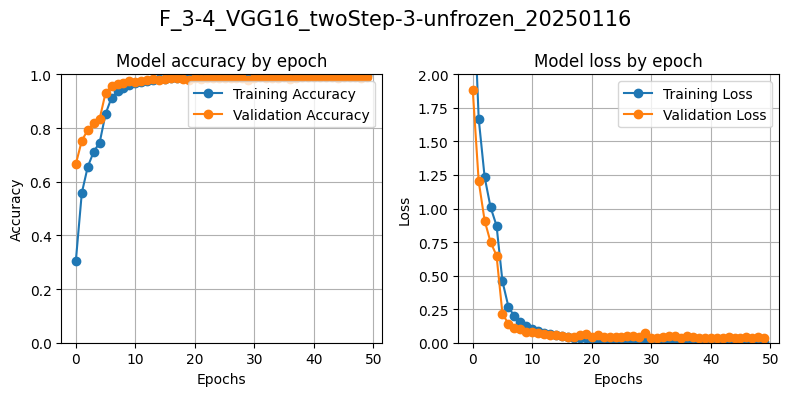

In [ ]:
fig= plt.figure(figsize=(8,4))
fig.suptitle(Model_name, fontsize=15)

# Plot accuracy
plt.subplot(121)
plt.plot(history_combined["accuracy"], label='Training Accuracy', marker='o')
plt.plot(history_combined["val_accuracy"], label='Validation Accuracy', marker='o')
plt.title('Model accuracy by epoch')
plt.xlabel('Epochs')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot loss
plt.subplot(122)
plt.plot(history_combined["loss"], label='Training Loss', marker='o')
plt.plot(history_combined["val_loss"], label='Validation Loss', marker='o')
plt.title('Model loss by epoch')
plt.xlabel('Epochs')
plt.ylim([0,2])
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Prediction & Classification report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
# Generate predictions for validation set
val_pred = model.predict(val_generator)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = val_generator.classes

# Classification report
class_report = classification_report(true_classes, val_pred_classes)
print("Classification Report:\n", class_report)

550/550 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       504
           1       1.00      1.00      1.00       497
           2       1.00      1.00      1.00       440
           3       0.99      0.99      0.99       502
           4       1.00      0.99      1.00       454
           5       1.00      1.00      1.00       421
           6       1.00      1.00      1.00       456
           7       0.98      0.95      0.97       410
           8       1.00      1.00      1.00       477
           9       0.96      0.99      0.97       477
          10       1.00      1.00      1.00       465
          11       1.00      0.99      0.99       472
          12       0.99      1.00      0.99       480
          13       1.00      1.00      1.00       430
          14       1.00      1.00      1.00       423
          15       1.00      1.00      1.00       503
          16  

Confusion matrix

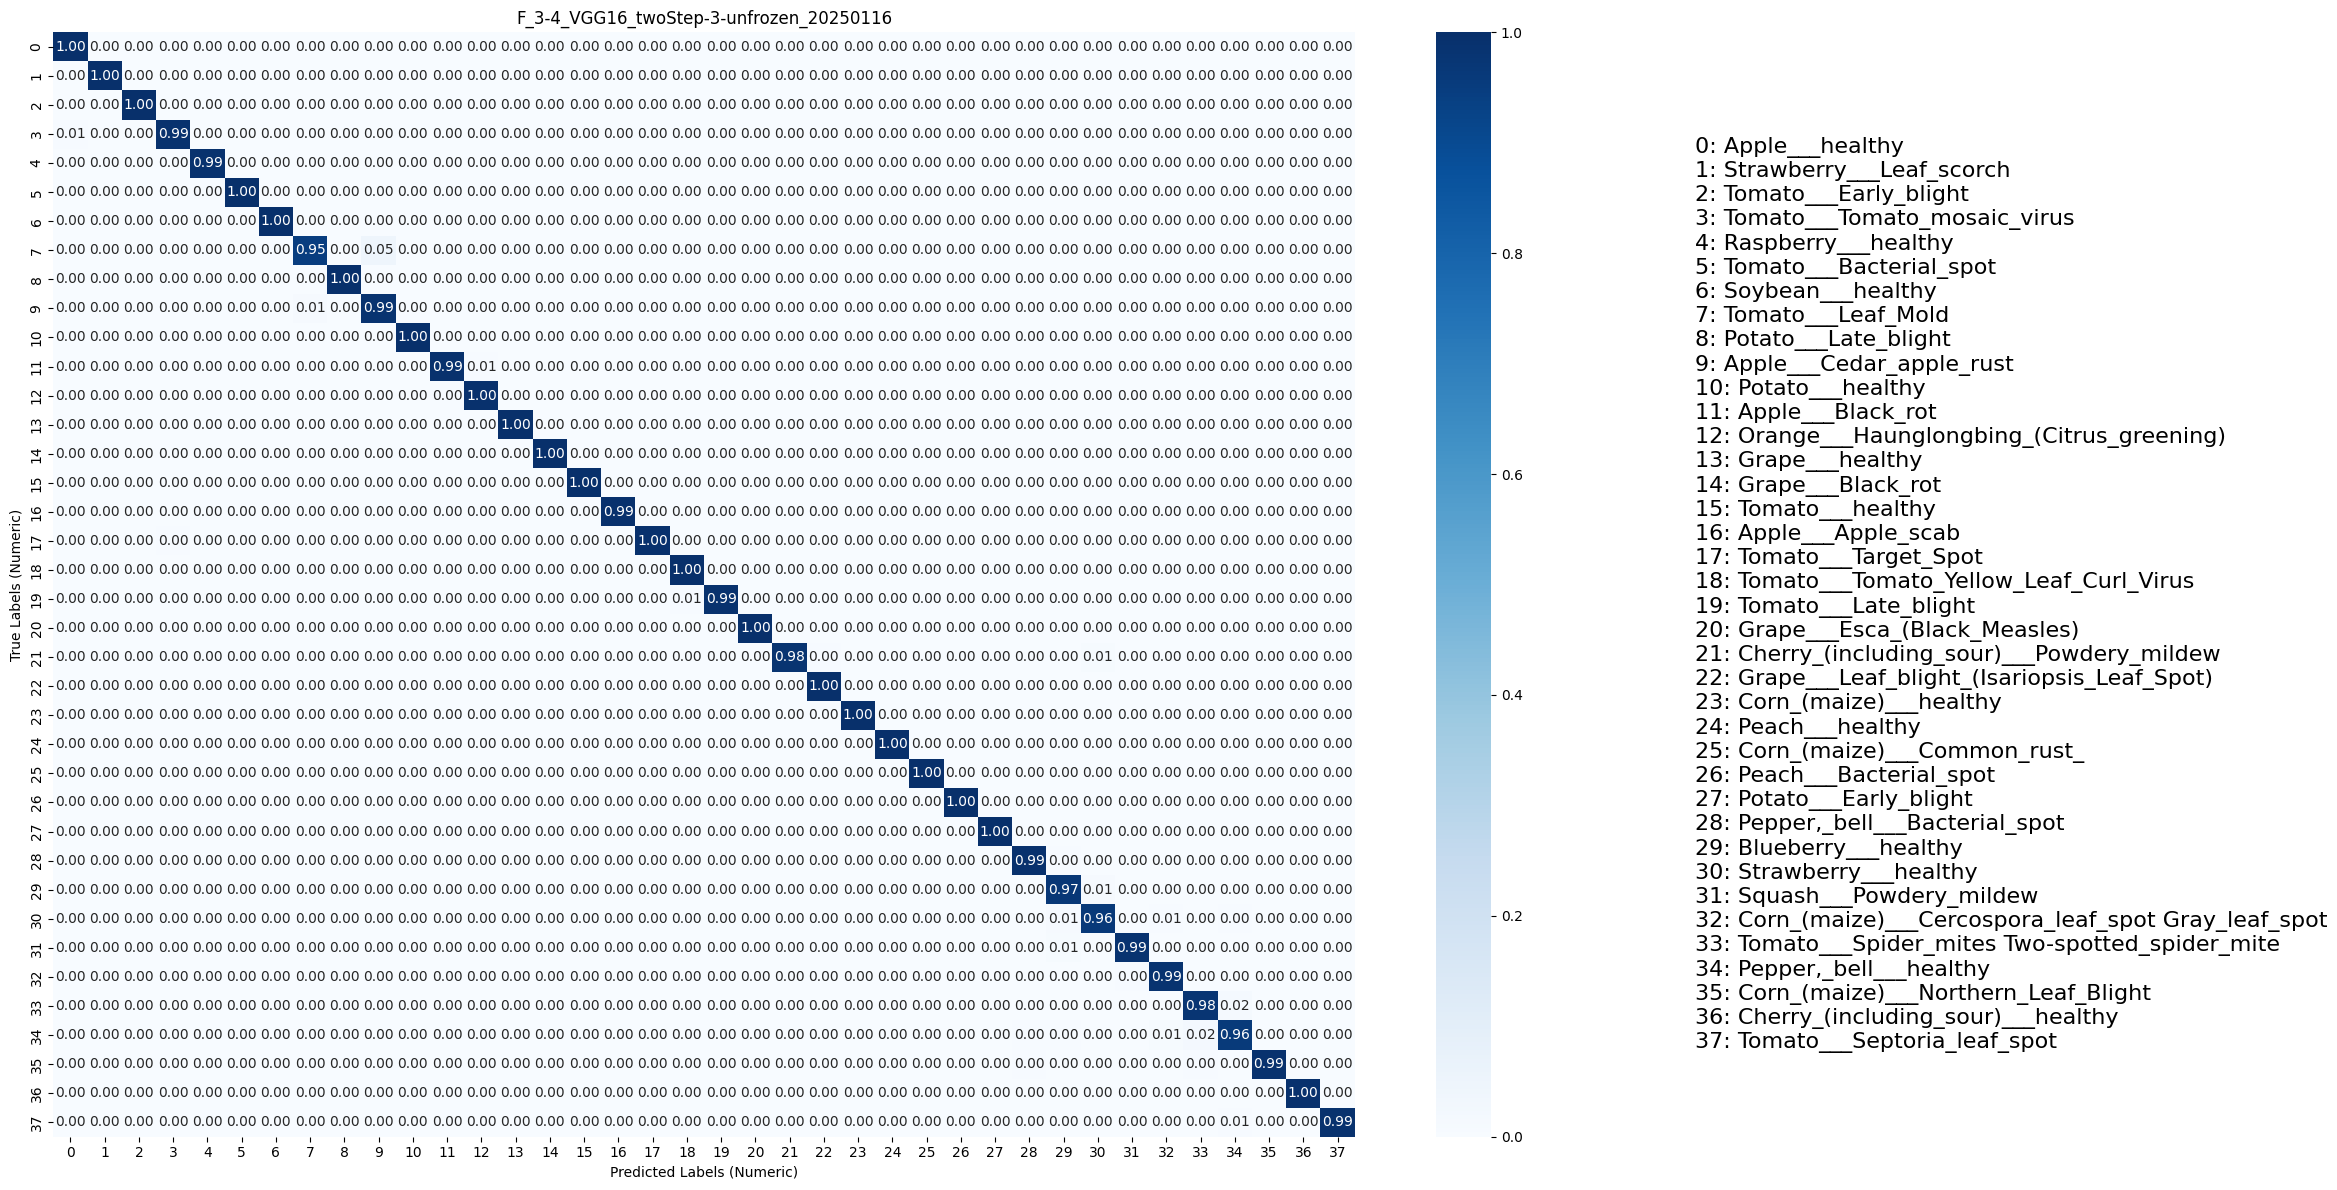

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix (y_true, y_pred, class_names, normalize=False, title=Model_name):
    """
    Plots a heatmap for the confusion matrix with numeric axis labels and a separate legend.

    Parameters:
    - y_true: Array of true labels
    - y_pred: Array of predicted labels
    - class_names: List of class names (for the legend)
    - normalize: If True, normalizes the confusion matrix
    - title: Title for the heatmap
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the heatmap
    plt.figure(figsize=(17, 12))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap='Blues', cbar=True,
                xticklabels=range(len(class_names)), yticklabels=range(len(class_names)))
    plt.title(title)
    plt.ylabel('True Labels (Numeric)')
    plt.xlabel('Predicted Labels (Numeric)')
    plt.tight_layout()

    # Add a legend for the class names
    plt.gcf().text(1, 0.5,
                   "\n".join([f"{i}: {name}" for i, name in enumerate(class_names)]),
                   fontsize=16, verticalalignment='center', horizontalalignment='left')

    plt.show()

# Extract class names
class_names = [folder_name for folder_name in os.listdir(valid_path) if os.path.isdir(os.path.join(valid_path, folder_name))]
#print("Class Names:", class_names)

plot_confusion_matrix(true_classes, val_pred_classes, class_names, normalize=True)




# Save model

In [ ]:
# os.rename('best_model.keras', f"{Model_name}.keras")
!ls


F_3_VGG16_all-frozen_2025011.keras  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/DataScientist_Projects/1_Plant_Recognition_Project/Models"
model.save(f"{save_dir}/{Model_name}.keras")

Mounted at /content/drive


# Evaluation on test folder

Evaluation on the test folder

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import re

# Define helper function to preprocess a single image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)  # Load image and resize
    img_array = img_to_array(img) / 255.0               # Convert to array and rescale
    return img_array

# Load and preprocess all images from the test folder
def load_test_images(test_path, target_size):
    test_images = []
    filenames = []
    for file in os.listdir(test_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Supported file formats
            file_path = os.path.join(test_path, file)
            test_images.append(preprocess_image(file_path, target_size))
            filenames.append(file)  # Save filenames for reference
    return np.array(test_images), filenames

# Function to check if prediction is correct based on common words
def is_prediction_correct(file_name, predicted_label):
    # Extract meaningful words from file name (split camel case or concatenated words)
    file_name = re.sub(r'\.\w+$', '', file_name)  # Remove file extension
    file_words = set(word.lower() for word in re.findall(r'[A-Z][a-z]*|[a-z]+', file_name))  # Handle camel case and lowercase

    # Extract meaningful words from predicted label
    label_words = set(word.lower() for word in re.findall(r'[A-Za-z]+', predicted_label))  # Convert to lowercase

    # Check if all file words are in the label words
    is_subset = file_words.issubset(label_words)

    # Debugging output to verify
    #print(f"File Words: {file_words}, Label Words: {label_words}, Is Subset: {is_subset}")

    return is_subset

# Parameters
IMG_SIZE = (224, 224)  # Adjust to model's input size
test_path = test_path  # Define the test folder path

# Load and preprocess test images
test_images, filenames = load_test_images(test_path, target_size=IMG_SIZE)

# Make Predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Map predictions to class labels
class_labels = train_generator.class_indices
class_indices = {v: k for k, v in class_labels.items()}  # Reverse mapping of class indices
predicted_labels = [class_indices[idx] for idx in predicted_classes]

# Process and evaluate predictions
results = []

for file, pred, label in zip(filenames, predictions, predicted_labels):
    confidence = np.max(pred)  # Get the highest probability (confidence score)
    is_correct = is_prediction_correct(file, label)  # Check prediction correctness
    results.append({"True class": file, "prediction": label, "confidence": confidence, "Correct": int(is_correct)})
    print(f"True class: {file}, Prediction: {label}, Confidence: {confidence:.2f}, Correct: {is_correct}")

# Summary of results
correct_predictions = sum(result['Correct'] for result in results)
total_predictions = len(results)
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f"Total Predictions: {total_predictions}, Correct: {correct_predictions}, Accuracy: {accuracy:.2%}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
True class: PotatoEarlyBlight2.JPG, Prediction: Potato___Early_blight, Confidence: 1.00, Correct: True
True class: AppleScab1.JPG, Prediction: Apple___Apple_scab, Confidence: 1.00, Correct: True
True class: TomatoHealthy3.JPG, Prediction: Tomato___healthy, Confidence: 0.97, Correct: True
True class: PotatoEarlyBlight1.JPG, Prediction: Potato___Early_blight, Confidence: 1.00, Correct: True
True class: AppleCedarRust3.JPG, Prediction: Apple___Cedar_apple_rust, Confidence: 1.00, Correct: True
True class: AppleScab3.JPG, Prediction: Apple___Apple_scab, Confidence: 0.92, Correct: True
True class: AppleScab2.JPG, Prediction: Apple___Apple_scab, Confidence: 1.00, Correct: True
True class: TomatoYellowCurlVirus3.JPG, Prediction: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Confidence: 1.00, Correct: True
True class: CornCommonRust1.JPG, Prediction: Corn_(maize)___Common_rust_, Confidence: 1.00, Correct: True
True class: TomatoHealthy1.JPG, Prediction: Tomato___he

Create DataFrame and save as CSV in google drive

In [ ]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Print the DataFrame
print("\nSummary of Predictions and Feedback:")
display(df_results)

# Save DataFrame to CSV
output_csv_path = f"{save_dir}/{Model_name}_predictions.csv"  # Specify the output file path
df_results.to_csv(output_csv_path, index=False)

print(f"Predictions have been saved to {output_csv_path}")


Summary of Predictions and Feedback:


,True class,prediction,confidence,Correct
0,PotatoEarlyBlight2.JPG,Potato___Early_blight,1.000000,1
1,AppleScab1.JPG,Apple___Apple_scab,0.999999,1
2,TomatoHealthy3.JPG,Tomato___healthy,0.973773,1
3,PotatoEarlyBlight1.JPG,Potato___Early_blight,1.000000,1
4,AppleCedarRust3.JPG,Apple___Cedar_apple_rust,0.999966,1
5,AppleScab3.JPG,Apple___Apple_scab,0.916186,1
6,AppleScab2.JPG,Apple___Apple_scab,1.000000,1
7,TomatoYellowCurlVirus3.JPG,Tomato___Tomato_Yellow_Leaf_Curl_Virus,1.000000,1
8,CornCommonRust1.JPG,Corn_(maize)___Common_rust_,1.000000,1
9,TomatoHealthy1.JPG,Tomato___healthy,0.999998,1


Predictions have been saved to /content/drive/MyDrive/DataScientist_Projects/1_Plant_Recognition_Project/Models/F_3-4_VGG16_twoStep-3-unfrozen_20250116_predictions.csv


Prediction accuracy

In [ ]:
df_results["Correct"].value_counts(normalize=True)

,proportion
Correct,
1,0.969697
0,0.030303
